In [1]:
import os
import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import utils, datasets, transforms
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# 设置随机种子

In [2]:
# Set random seed for reproducibility
torch.manual_seed(0)

# 超参数配置

In [3]:
# Root directory for dataset
dataroot = "data/mnist"

# Number of workers for dataloader
workers = 12

# Batch size during training
batch_size = 100

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# 数据集

In [4]:
train_data = datasets.MNIST(
    root=dataroot,
    train=True,
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]),
    download=True
)
test_data = datasets.MNIST(
    root=dataroot,
    train=False,
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
)
dataset = train_data+test_data
print(f'Total Size of Dataset: {len(dataset)}')

Total Size of Dataset: 70000


# 数据加载器

In [5]:
dataloader = DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers
)

# 选择训练设备

In [6]:
device = torch.device('cuda:0' if (torch.cuda.is_available() and ngpu > 0) else 'cpu')

# 训练数据可视化

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


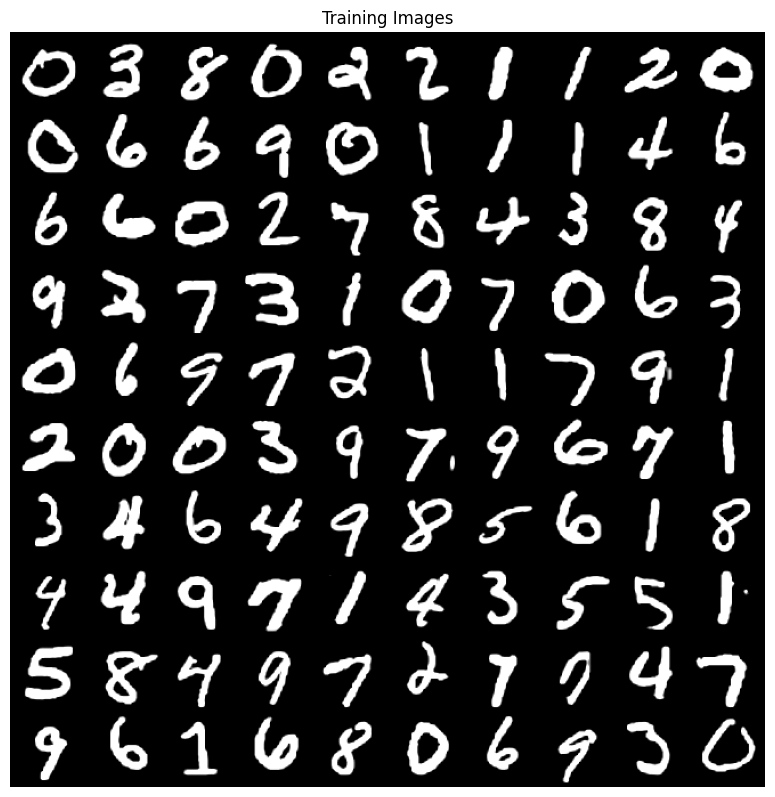

In [7]:
inputs = next(iter(dataloader))[0]
plt.figure(figsize=(10,10), dpi=100)
plt.title("Training Images")
plt.axis('off')
inputs = utils.make_grid(inputs[:100], nrow=10)
plt.imshow(inputs.permute(1, 2, 0))

# 权重初始化
在DCGAN论文中，作者指出所有模型权重应当从均值为**0**，标准差为**0.02**的正态分布中随机初始化。`weights_init`函数以初始化的模型为输入，重新初始化所有卷积层、反卷积层和批标准化层，以满足这一标准。该函数在初始化后立即应用于模型。

In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# 生成器
生成器$G$用于将潜在空间向量$z$映射到数据空间。由于我们的数据是图像，因此将$z$转换到数据空间意味着最终创建与训练图像大小相同的RGB图像（即1x64x64）。

实际上，这是通过一系列的二维反卷积层来完成的，每层都配带有批标准化层和relu激活。生成器的输出最终经过**tanh**函数处理，以使其返回到[-1, 1]的输入数据范围。

值得注意的是，在反卷积层之后存在批标准化函数，这是DCGAN论文中的关键贡献。这些层有助于训练过程中的梯度流动，DCGAN论文中生成器的一张图片如下。

![](https://img-blog.csdnimg.cn/img_convert/85974d98be6202902f21ce274418953f.png)

In [9]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [10]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if device.type == 'cuda' and ngpu > 1:
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.2.
# netG.apply(weights_init)

# 判别器
如前所述，判别器$D$是一个二分类网络，该网络将图像作为输入，并输出该图是真（与假相对）的标量概率。

这里，$D$以1x64x64的图像作为输入，通过一系列的`Conv2d`，`BatchNorm2d`和`LeakyReLU`层的处理，然后通过`Sigmoid`激活函数输出最终概率。对于这个问题，如果需要的话，这个体系结构可以扩展更多的层，但是使用`strided convolution`，`BatchNorm`和`LeakyReLUs`具有重要意义。DCGAN论文提到，使用`strided convolution`而不是通过池化来进行下采样是个好方法，因为它可以让网络学习自己的池化函数。 `batch norm`和`leaky relu`函数还可以促进健康的梯度流动，这对于$G$和$D$的学习过程都至关重要。

In [11]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            # state size. (1) x 1 x 1
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [12]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if device.type == 'cuda' and ngpu > 1:
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.2.
# netD.apply(weights_init)

In [13]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize the progression of the generator
fixed_noise = torch.randn(100, nz, 1, 1, device=device)
# print(f'Size of Latent Vector: {fixed_noise.size()}')

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [14]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
D_x_list = []
D_z_list = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    beg_time = time.time()
    # For each batch in the dataloader
    for i, data in enumerate(dataloader):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0) # 64*8
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        # Forward pass real batch through D
        output = netD(real_cpu).view(-1) # output.size()=[128]

        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        end_time = time.time()
        run_time = round(end_time-beg_time)
        print(
            f'Epoch: [{epoch+1:0>{len(str(num_epochs))}}/{num_epochs}]',
            f'Step: [{i+1:0>{len(str(len(dataloader)))}}/{len(dataloader)}]',
            f'Loss-D: {errD.item():.4f}',
            f'Loss-G: {errG.item():.4f}',
            f'D(x): {D_x:.4f}',
            f'D(G(z)): [{D_G_z1:.4f}/{D_G_z2:.4f}]',
            f'Time: {int(run_time/60)}m{run_time%60}s',
            end='\r'
        )

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Save D(X) and D(G(z)) for plotting later
        D_x_list.append(D_x)
        D_z_list.append(D_G_z2)
        

        # Check how the generator is doing by saving G's output on fixed_noise
        iters += 1
        if (iters % 100 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(utils.make_grid(fake, nrow=10))
    print()

Starting Training Loop...
Epoch: [1/5] Step: [700/700] Loss-D: 8.8328 Loss-G: 5.1051 D(x): 0.9995 D(G(z)): [0.9989/0.0200] Time: 1m6ssss
Epoch: [2/5] Step: [700/700] Loss-D: 2.5174 Loss-G: 0.7627 D(x): 0.1362 D(G(z)): [0.0006/0.5085] Time: 1m8sss
Epoch: [3/5] Step: [700/700] Loss-D: 0.0355 Loss-G: 4.4222 D(x): 0.9767 D(G(z)): [0.0113/0.0163] Time: 1m8sss
Epoch: [4/5] Step: [700/700] Loss-D: 0.9482 Loss-G: 1.9022 D(x): 0.6590 D(G(z)): [0.3345/0.1798] Time: 1m8sssG(z)): [0.1599/0.0005] Time: 0m1s
Epoch: [5/5] Step: [700/700] Loss-D: 0.0939 Loss-G: 3.1018 D(x): 0.9168 D(G(z)): [0.0025/0.0698] Time: 1m8sss


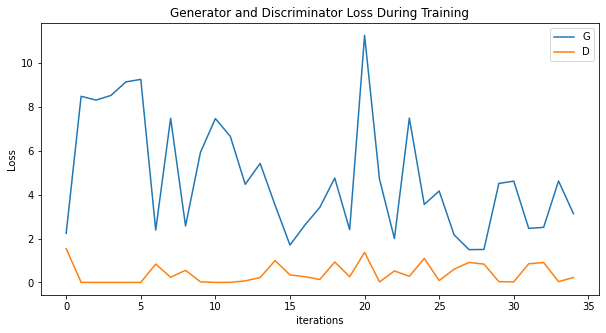

In [33]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses[::100], label="G")
plt.plot(D_losses[::100], label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

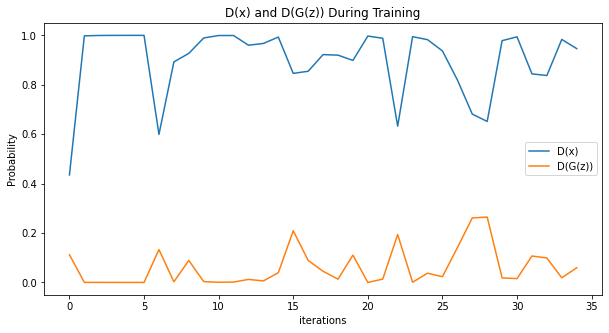

In [34]:
plt.figure(figsize=(10, 5))
plt.title("D(x) and D(G(z)) During Training")
plt.plot(D_x_list[::100], label="D(x)")
plt.plot(D_z_list[::100], label="D(G(z))")
plt.xlabel("iterations")
plt.ylabel("Probability")
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 1000x1000 with 0 Axes>

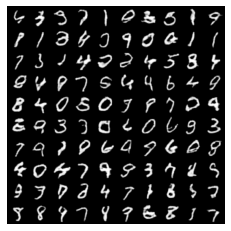

In [36]:
#%%capture
fig = plt.figure(figsize=(10, 10), dpi=100)
fig = plt.figure()
plt.axis("off")
ims = [[plt.imshow(item.permute(1, 2, 0), animated=True)] for item in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


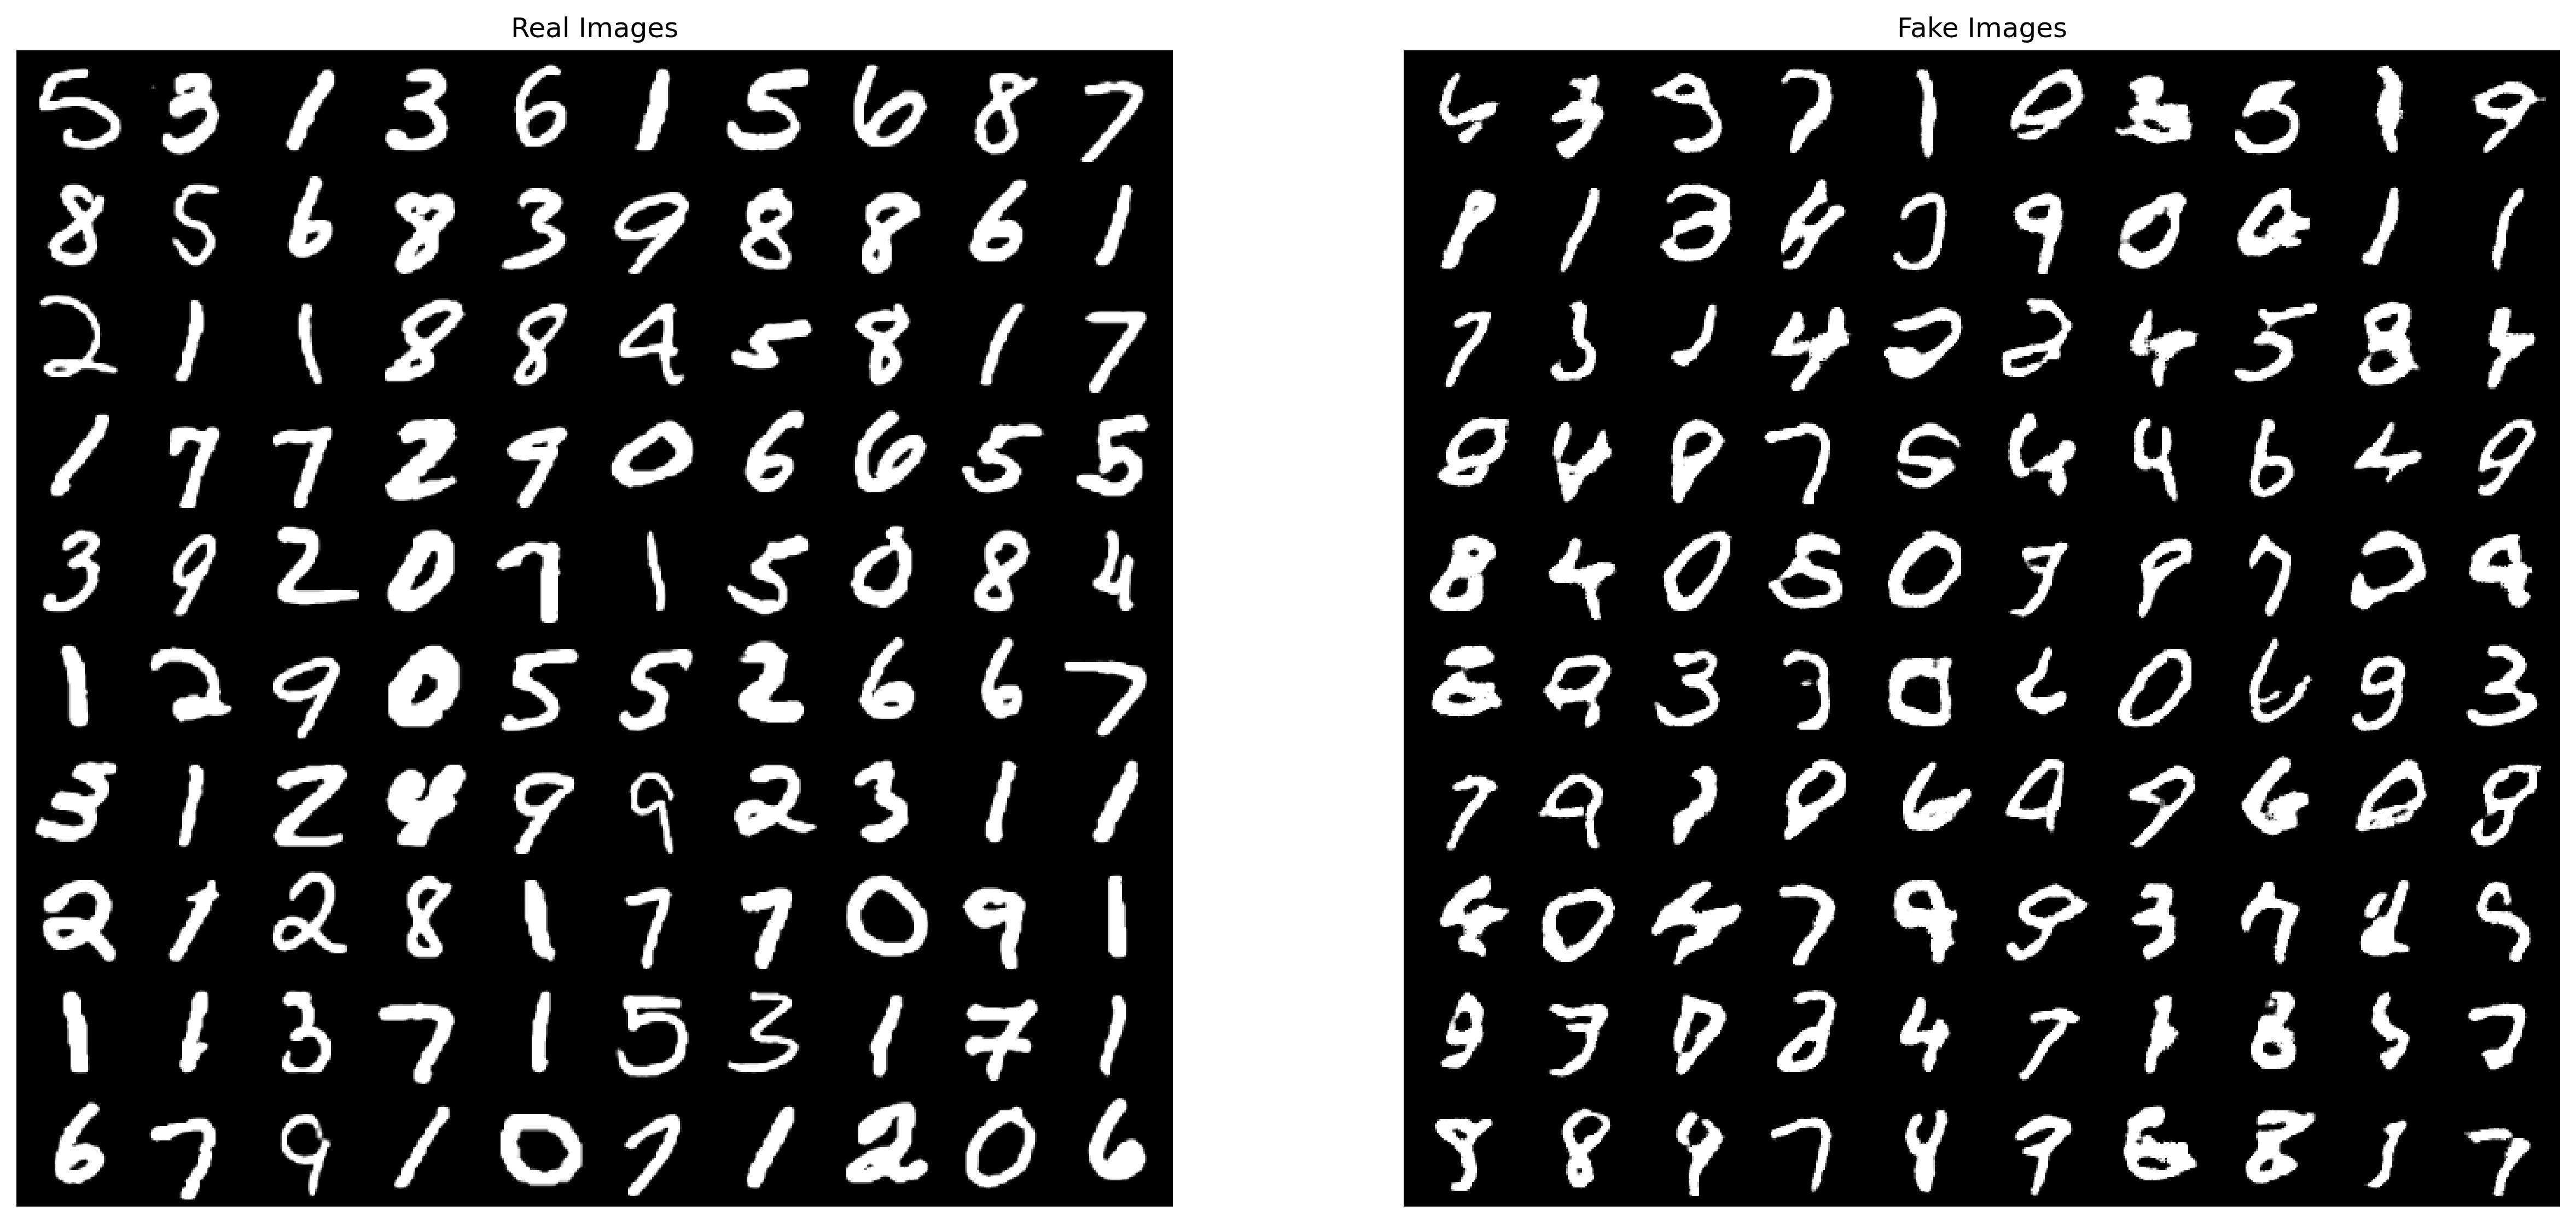

In [20]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))


# Plot the real images
plt.figure(figsize=(20,10), dpi=300)
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(utils.make_grid(real_batch[0][:100], nrow=10).permute(1, 2, 0))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.savefig('comparation.jpg', )
plt.imshow(transforms.Normalize((0.1307,), (0.3081,))(img_list[-1]).permute(1, 2, 0))